In [1]:
import cv2
import numpy as np
from datascience import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import sys
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
images = []
image_names = []
labeled_imgs = []
original_img1 = []

original_img = []
filter_img = []

__Notes__:


__Approach__: Trying to use a block size in the middle of a block size used for large scales and small scales create an initial binarization that will help us figure out the best adpative block size and iteration amount.
                
                
__Noise__: Also exploring how to remove noise. In this code as a last step I remove spots that are significantly smaller than the average scale size.

__TODO__: Thinking of applying watershed segmentation at the end to remove overlapping scales. We also need to refine the current process by which we decide the block size and iteration size for our adapative thresholding approach.

In [3]:
#access img directory
dirname = 'More_images/'

#create an iterator object for img directory
directory = os.scandir(dirname)

print(os.listdir(dirname))

def initial_binarization(initial_block_size, initial_iteration, customized):
    index = 0;
    images.clear
    
    #iterates through each image in the directory
    for img in directory:
        img_name = img.name
        if (img_name != '.ipynb_checkpoints'):
            
            image_names.append(img.name)
            
            #read the image, convert to grayscale add to array and title + blur
            img = cv2.imread(dirname + "" + img_name)
            original_img1.append(img)
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            original_img.append(gray)
            title = img_name
            img = gray
#             img = img-np.min(img)
#             img = img/np.max(img)*255
#             img /= 2
#             c = 255 / np.log(1 + np.max(img)) 
#             log_image = c * (np.log(img + 1)) 
#             log_image = np.array(log_image, dtype = np.uint8)
            
            #log = np.log(gray)
            #log = log-np.min(log+1)
            #log = log/np.max(log)*255
            #log = log.astype(float)
            
            #blur = cv2.GaussianBlur(log_image,(5,5),0)
            blur = cv2.GaussianBlur(img,(5,5),0)
            blur = cv2.bilateralFilter(blur,20,10,60)
            
            filter_img.append(blur)
            #if the customized block size has not yet been determined this if statement will run
            if(len(customized)==0):
                #print("Initial Value used")
                thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, initial_block_size, -2)
           
            #if customized block size has been determined
            else:
                print("Customized Values used")
                print(block_size[index][0], block_size[index][1])
                thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size[index][0], -2)
                
            kernel = np.ones((3,3),np.uint8)
            
            #if the customized iteration number has not yet been determined this if statement will run
            if(len(customized)==0):
                opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)
            
            #if customized array is greater than size 0 iteration number has been determined
            else:
                opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=block_size[index][1])

            
            # sure background area
            sure_bg = cv2.dilate(opening,kernel,iterations=1)

            # Finding sure foreground area: What does cv2.DIST do?
            dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
            ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0) 

            # Finding unknown region
            sure_fg = np.uint8(sure_fg)
            unknown = cv2.subtract(sure_bg,sure_fg)
            
            #adding sure_fg binarization to list of images
            images.append(sure_fg)

            #plt.subplot(1,3,1), plt.imshow(gray, 'gray')
            #plt.subplot(1,3,2), plt.imshow(sure_fg, 'gray')
            
            
            # Label and count (taken from maggie's code)
            # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
            count, labels = cv2.connectedComponents(sure_fg)                
            count = count - 1 # background doesn't count as a scale
            label_hue = np.uint8(179 * labels / np.max(labels))
            blank_ch = 255 * np.ones_like(label_hue)
            labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
            labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
            labeled_img[label_hue == 0] = 0
            
            if(len(customized) != 0):
                labeled_imgs.append(labeled_img)

            #plt.subplot(1, 3, 3), plt.imshow(labeled_img, 'gray')
            #plt.title('Count: ' + str(count))
            #plt.show()
            index += 1

print("INITIAL TEST BINARIZATION\n")
initial_binarization(41, 4, [])
    

['235227Ventral-Flash-1.png', '235227Ventral-NoFlash-1.png', '235227Ventral-Flash-2.png', '235227Ventral-NoFlash-2.png', '135164_V-3png.png', '135164_V-1.png', '135164_V-2.png', '135164_D-3.png', '135164_D-2.png', '235237Dorsal-Flash-2.png', '135164_D-1.png', '235237Dorsal-Flash-1.png', '235233Dorsal-Flash-1.png']
INITIAL TEST BINARIZATION



In [4]:
'''
img = original_img[9]

plt.imshow(img, 'gray')
plt.show()

log = np.log(img)
log = log-np.min(log+1)
log = log/np.max(log)*255
log = log.astype(float)
plt.imshow(log, 'gray')
plt.show()

blur = cv2.GaussianBlur(log,(5,5),0)
#blur = cv2.GaussianBlur(blur,(5,5),0).astype(int)
blur = cv2.bilateralFilter(blur,20,10,200)

plt.imshow(blur, 'gray')
plt.show()
'''

"\nimg = original_img[9]\n\nplt.imshow(img, 'gray')\nplt.show()\n\nlog = np.log(img)\nlog = log-np.min(log+1)\nlog = log/np.max(log)*255\nlog = log.astype(float)\nplt.imshow(log, 'gray')\nplt.show()\n\nblur = cv2.GaussianBlur(log,(5,5),0)\n#blur = cv2.GaussianBlur(blur,(5,5),0).astype(int)\nblur = cv2.bilateralFilter(blur,20,10,200)\n\nplt.imshow(blur, 'gray')\nplt.show()\n"

In [5]:
#Factors that go into seeing if a scale is correct: size of the scale: distance of the scale to other scales
#Maybe look also at the distance of the scale from the
#arrays that keep track of important measurements
average_size = []
scale_num_per_img = []
sizes_of_scales = []
total_stats = []

#iterates through images to determine average size and count of scales in initial binarization

for i in np.arange(len(images)):
    img = images[i]
    #plt.imshow(img)
    #plt.show()

    binary_map = (img > 0).astype(np.uint8)
    connectivity = 4 # or whatever you prefer
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)

    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
     
    #print("Sizes of all scales:", stats[1:,-1])
    print("Number of scales detected (including noise)", num_labels - 1)
    print("Average size of scales: ", np.average(stats[1:,-1]))
    print("\n")
    
    sizes_of_scales.append((stats[1:,-1]))
    average_size.append(([num_labels, np.average(stats[1:,-1])]))
    total_stats.append([num_labels,stats[1:,-1], stats[1:,-1]])

    

Number of scales detected (including noise) 9
Average size of scales:  116.22222222222223


Number of scales detected (including noise) 4
Average size of scales:  112.25


Number of scales detected (including noise) 4
Average size of scales:  106.5


Number of scales detected (including noise) 3
Average size of scales:  98.66666666666667


Number of scales detected (including noise) 5
Average size of scales:  809.6


Number of scales detected (including noise) 7
Average size of scales:  460.2857142857143


Number of scales detected (including noise) 6
Average size of scales:  569.1666666666666


Number of scales detected (including noise) 2
Average size of scales:  74.5


Number of scales detected (including noise) 6
Average size of scales:  110.33333333333333


Number of scales detected (including noise) 0
Average size of scales:  nan


Number of scales detected (including noise) 7
Average size of scales:  114.14285714285714


Number of scales detected (including noise) 0
Average size

__Desicions__
Based on the results of the initial binarization in the code below we deicide a block size and a iteration amount:

1. If nothing shows up in initial binarization this indicates small scales: block size is 15 iteration is 1
2. If sclaes do show up but average area size of scales is less than 350 pixel: use block size 25 and iteration 2
3. If scales do show up but average area size of scales greater than 350 pixel: use block size 75 and iteration 1

In [6]:
#array that stores final block size and iteration statistics
block_size = []

#tentative if statements: based on initial binarization determines block and iteration size
for stat in average_size:
    index = 0
    if stat[0] <= 1:
        block_size.append([15,1])
        
    elif stat[1] < 350 and max(sizes_of_scales[index]) < 300:
        block_size.append([21, 2])
    
    elif stat[1] < 350 and max(sizes_of_scales[index]) > 300:
        block_size.append([25, 2])
        
    else:
        block_size.append([65, 2])
        index +=1 


size_and_it = Table().with_columns("img_name", image_names, "block_size", [i[0] for i in block_size], "iterations" ,[i[1] for i in block_size])
size_and_it.show()



img_name,block_size,iterations
235227Ventral-Flash-1.png,21,2
235227Ventral-NoFlash-1.png,21,2
235227Ventral-Flash-2.png,21,2
235227Ventral-NoFlash-2.png,21,2
135164_V-3png.png,65,2
135164_V-1.png,65,2
135164_V-2.png,65,2
135164_D-3.png,21,2
135164_D-2.png,21,2
235237Dorsal-Flash-2.png,15,1


In [7]:
dirname = 'More_images/'

#create an iterator object for img directory
directory = os.scandir(dirname)
images = []
initial_binarization(0, 0, block_size)



Customized Values used
21 2
Customized Values used
21 2
Customized Values used
21 2
Customized Values used
21 2
Customized Values used
65 2
Customized Values used
65 2
Customized Values used
65 2
Customized Values used
21 2
Customized Values used
21 2
Customized Values used
15 1
Customized Values used
21 2
Customized Values used
15 1
Customized Values used
15 1


In [8]:
initial_binarization(41, 4,[])

In [9]:
all_scale_counts = [i[0] for i in total_stats]
all_sizes = [i[1] for i in total_stats]

#sorts all_sizes so that the sizes of the scales are arranged from largest to smallest in array
for array_index in np.arange(len(all_sizes) - 1):
        all_sizes[array_index].sort()
        all_sizes[array_index] = all_sizes[array_index][::-1]

averages = []
for size_array in all_sizes:
    num_nums = (np.rint(len(size_array)/2)).astype(int)
    averages = np.append(averages, np.average(size_array[0:num_nums]))
    
print(averages)

[ 179.    143.5   155.5   107.5  1473.5   664.75  814.     99.    154.
     nan  139.       nan     nan]


In [10]:
def overlay(bw_img, color_mask, w1=0.2, w2=0.95):
    a = cv2.cvtColor(bw_img, cv2.COLOR_GRAY2RGB)
    a -= np.min(a)
    a = a/np.max(a)*255
    a = np.clip(a, a_min=0, a_max=255).astype(int)
    #a = np.array([[i.tolist()+[0] if np.max(i)==0 else i.tolist()+[255] for i in j] for j in a])
    
    b = np.clip(color_mask, a_min=0, a_max=255).astype(int)
    #b = np.array([[i.tolist()+[255] for i in j] for j in b])
    c = cv2.addWeighted(b,w1,a,w2,0)
    return c

__NOISE REMOVAL__

TRYING TO CLEAN UP THE IMAGES AND REMOVE SMALL SPECKELS: SHOULD TAKE INTO ACCOUNT DISTANCE AND SIZE
21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


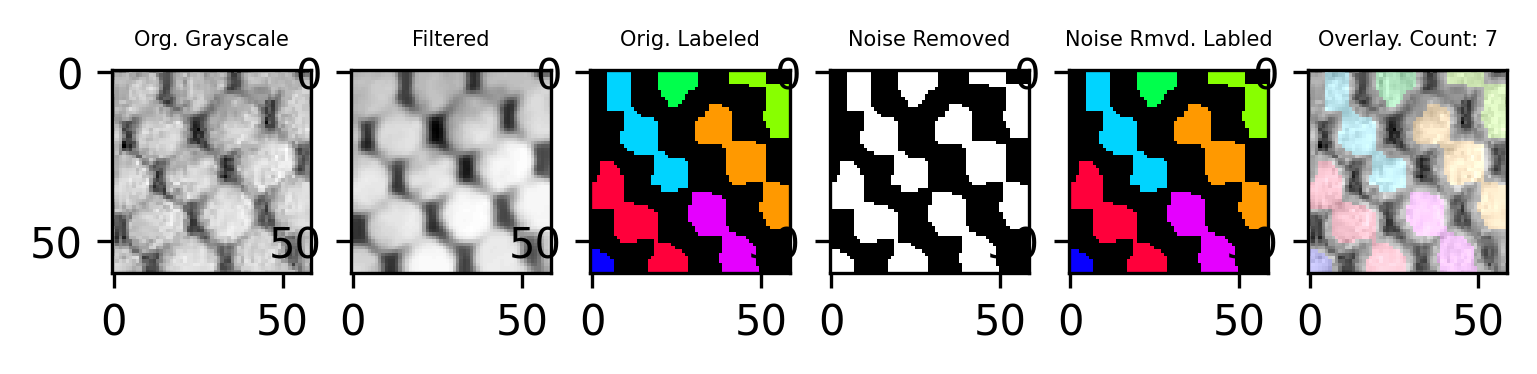

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


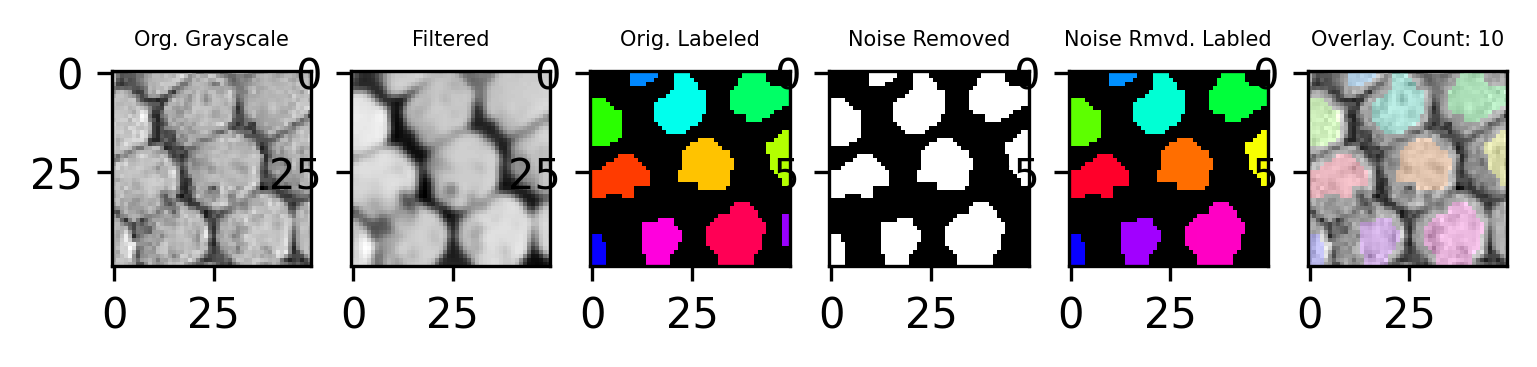

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


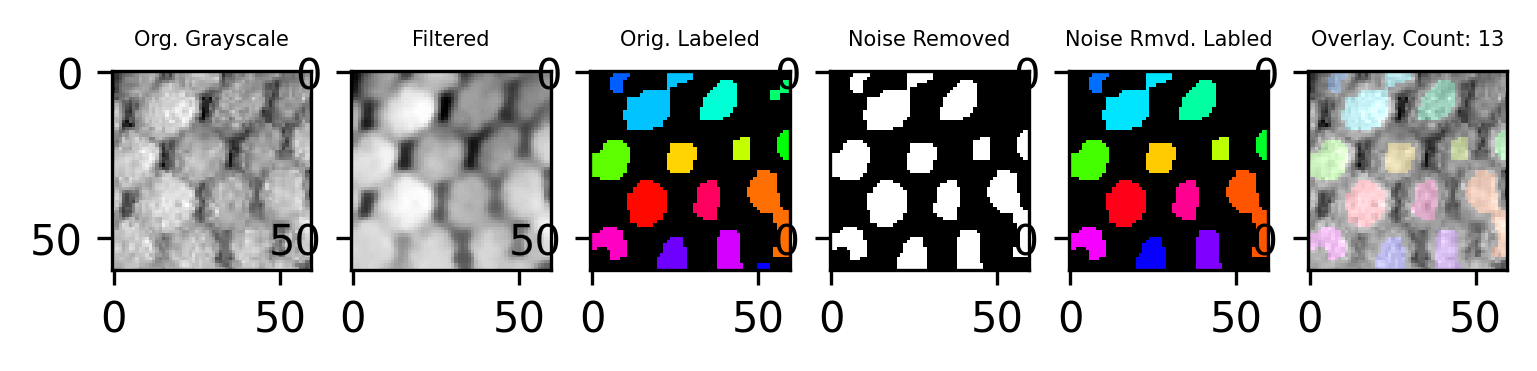

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


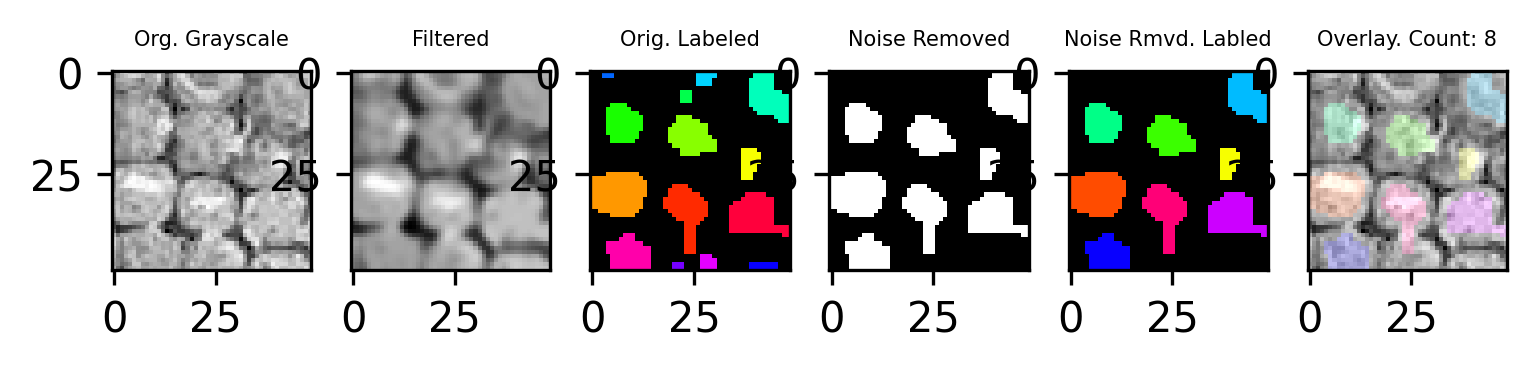

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65


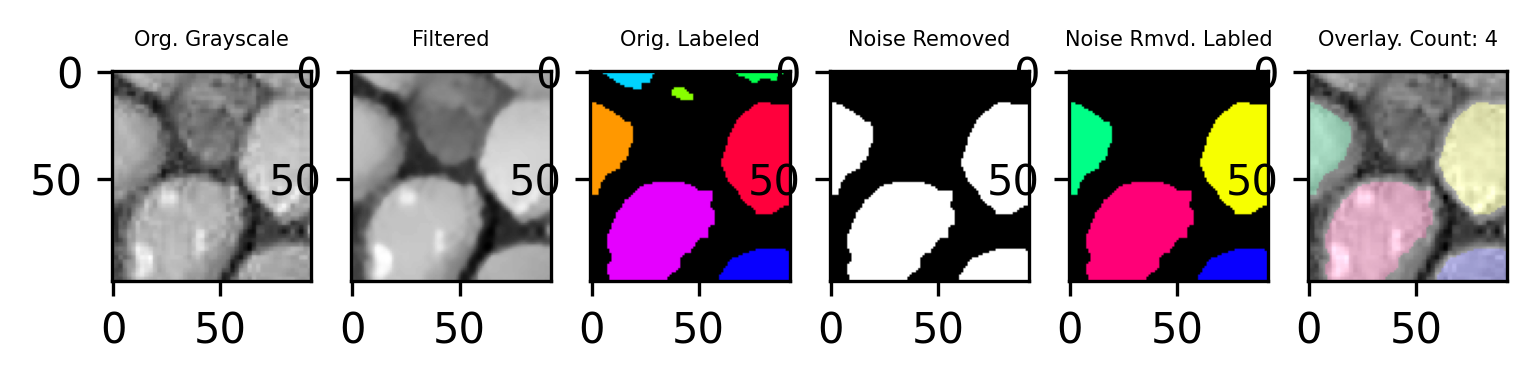

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65


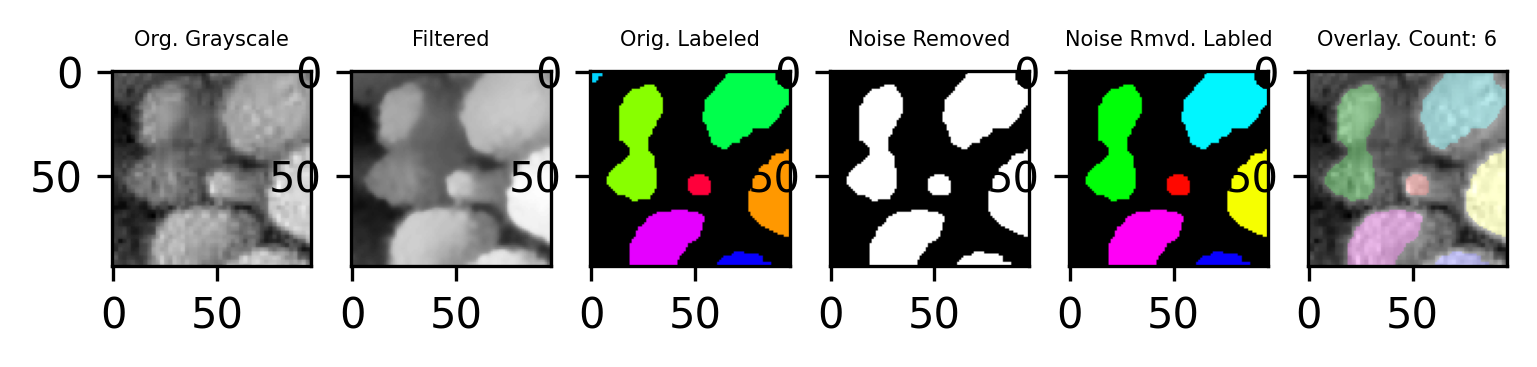

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65


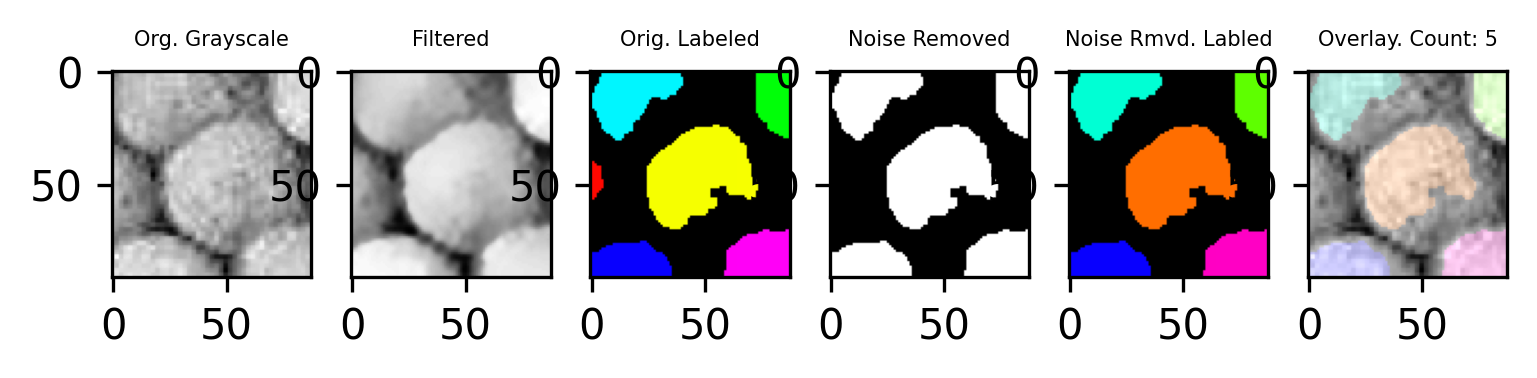

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


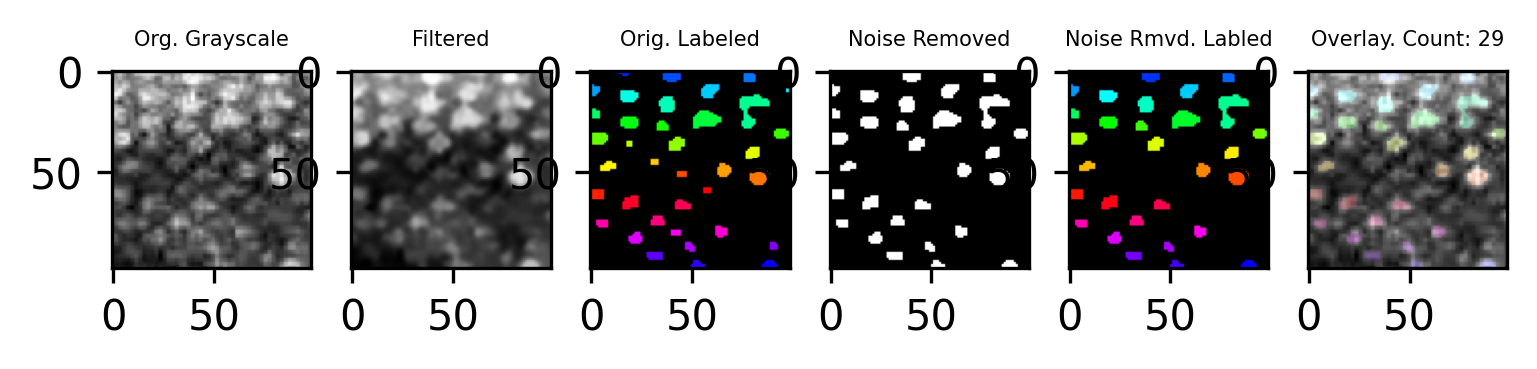

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


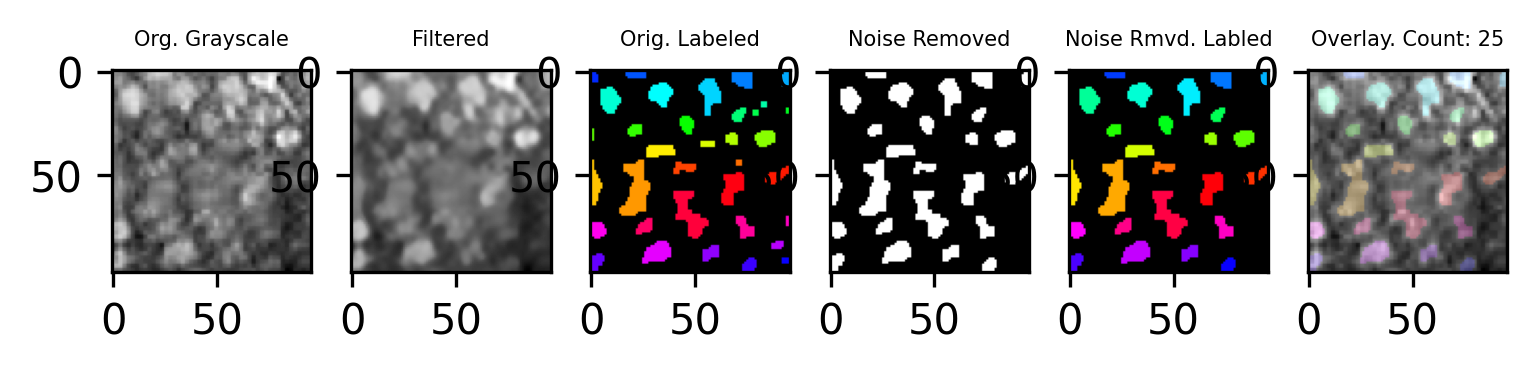

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


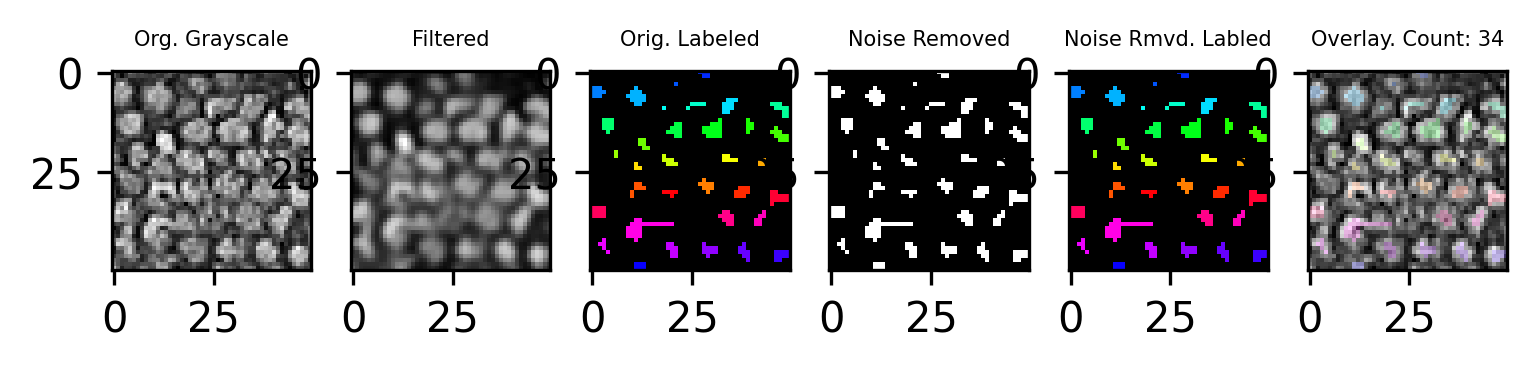

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


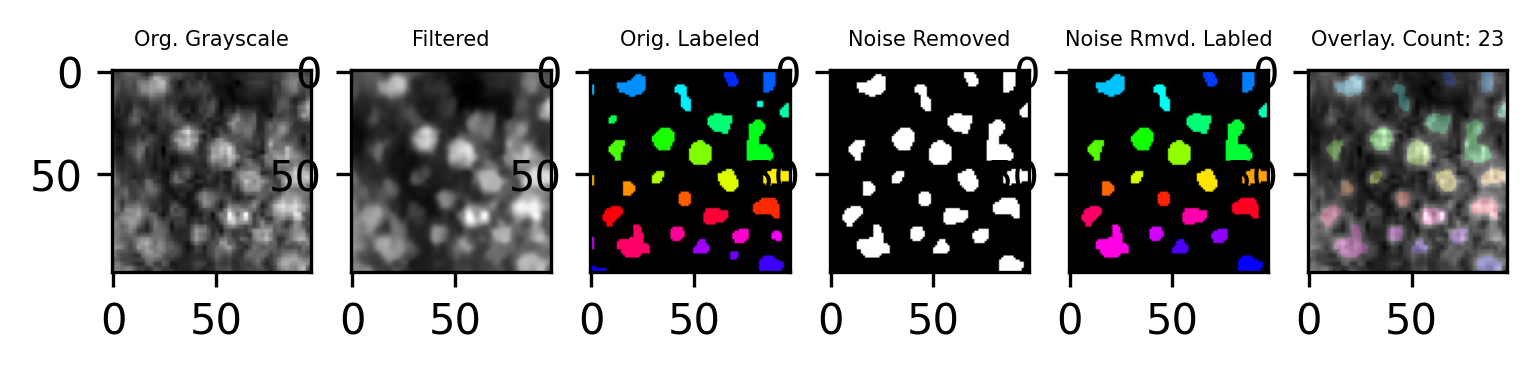

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


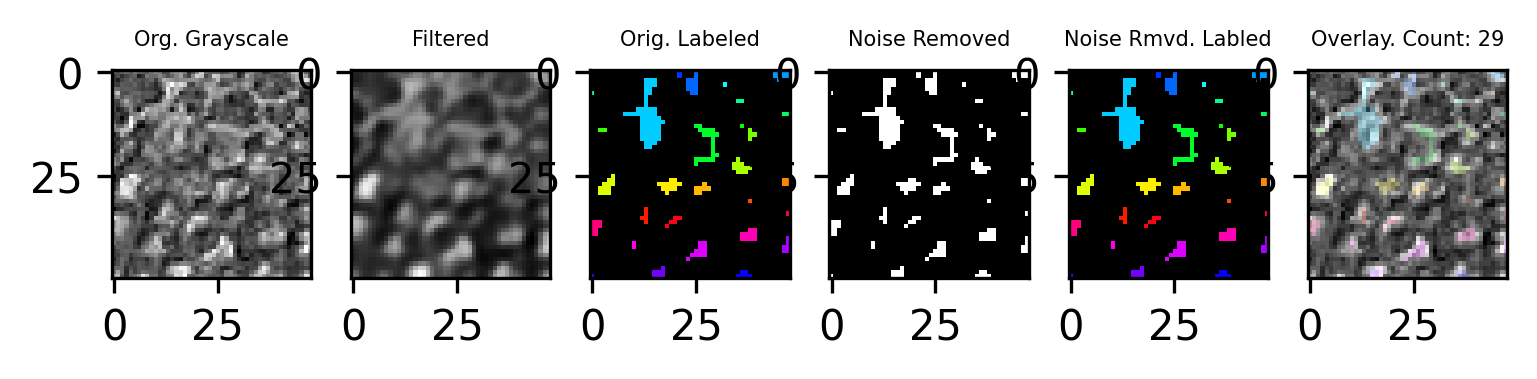

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


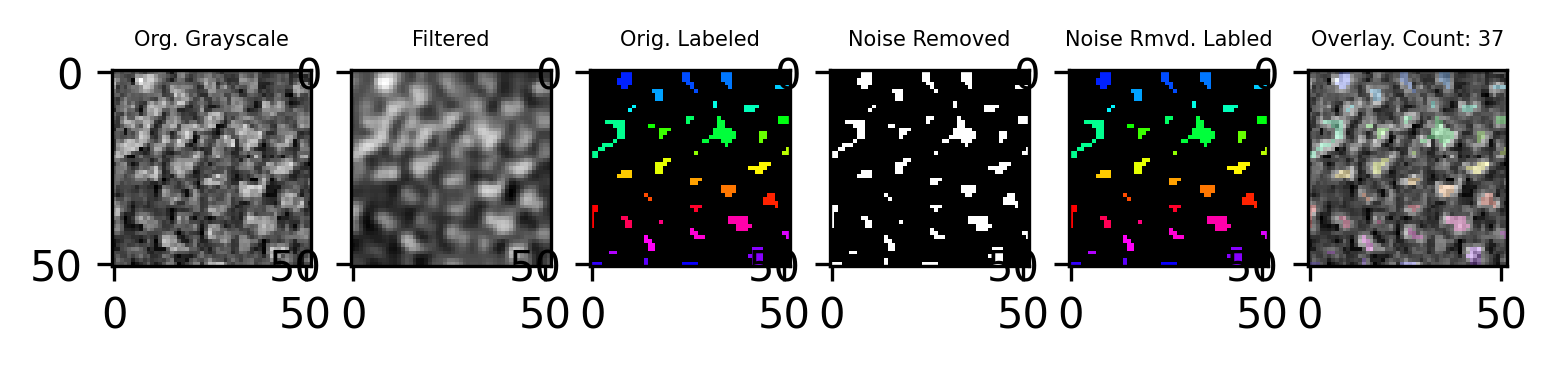

In [11]:
without_r = []
print("TRYING TO CLEAN UP THE IMAGES AND REMOVE SMALL SPECKELS: SHOULD TAKE INTO ACCOUNT DISTANCE AND SIZE")

index = 0;
for img in images:
    binary_map = (img > 0).astype(np.uint8)
    connectivity = 4 # or whatever you prefer
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
    stats = output[2]


    kernel = np.ones((3,3),np.uint8)
    #opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
    #closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 1)

    
    #review: what exactly does this do?
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < (averages[index]/10):
            img = cv2.drawContours(img, [c], -1, (0,0,0), -1)
    
    print(block_size[index][0])
    plt.subplot(1,6,1), plt.imshow(original_img[index], 'gray')
    plt.title("Org. Grayscale", fontsize=5)
    plt.subplot(1,6,2), plt.imshow(filter_img[index], 'gray')
    plt.title("Filtered", fontsize=5)
    plt.subplot(1,6,3), plt.imshow(labeled_imgs[index], 'gray')
    plt.title("Orig. Labeled", fontsize=5)
    plt.subplot(1,6,4), plt.imshow(img, 'gray')
    plt.title("Noise Removed", fontsize=5)


    # Label and count (taken from maggie's code)
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    count, labels = cv2.connectedComponents(img)                
    count = count - 1 # background doesn't count as a scale
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    without_r.append(labeled_img)

    plt.subplot(1, 6, 5), plt.imshow(labeled_img, 'gray')
    plt.title("Noise Rmvd. Labled", fontsize=5)
    plt.subplot(1, 6, 6), plt.imshow(overlay(original_img[index], labeled_img))
    
    
    plt.title("Overlay. Count: " + str(count), fontsize=5)



    plt.show()
    index = index + 1


    

__NOTES__
In the following code we expeariment with how optimizing roundness (which we calculated as the area of the scale/area of surrounding box) effects the count and segmentation.

In [12]:
ws = []
def countScales(img, calculated_block_size, orig_labeled):
    block_range = make_array(calculated_block_size- 10, calculated_block_size, calculated_block_size+ 10)
    maxRoundness = 0
    for blockSize in block_range: # blocksize must be odd number
        roundness, count, labeled_img = threshold(img, blockSize)
        if roundness > maxRoundness:
            maxRoundness = roundness
            bestCount = count
            bestSize = blockSize
            bestImage = labeled_img
        else:
            remove = ws.pop()
    displayFinal(img, bestImage, bestCount, bestSize, orig_labeled )

In [13]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
import imutils
import cv2
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to input image")
args = vars(ap.parse_args())
# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
image = cv2.imread(args["image"])
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
cv2.imshow("Input", image)
# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2.imshow("Thresh", thresh)

usage: ipykernel_launcher.py [-h] -i IMAGE
ipykernel_launcher.py: error: the following arguments are required: -i/--image


SystemExit: 2

In [14]:
def threshold(img, blockSize):
    #img = cv2.imread(imgName)
    
    # convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    print(blockSize)
    
    gray = img
    
    # blur and adaptive thresholding
    # source: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
    blur = cv2.GaussianBlur(gray,(5,5),0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, -2)

    # Remove noise by opening
    kernel = np.ones((3,3),np.uint8)
    if blockSize > 25:
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations=2)
    
    if blockSize <= 25:
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations=1)
        
    
    # Check if opening was too much
    numWhitePixels = cv2.countNonZero(opening) # number of foreground pixels
    totalPixels = img.size / 3 # not sure why it has to be divided by 3
    if numWhitePixels / totalPixels < 0.3:
        # if opening resulted in less than 30% foreground, decrease number of opening iterations
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations=1)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0)
    sure_fg = np.uint8(sure_fg)

    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, indices=False, min_distance=25,
        labels=thresh)
    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then appy the Watershed algorithm
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh)
    print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
    ws.append(labels)
    


    # Label and count
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    output = cv2.connectedComponentsWithStats(sure_fg, 8, cv2.CV_32S)
    labels = output[1]
    count = output[0] - 1 # background doesn't count as a scale
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    
    
    stats = output[2]
    areas = []
    ratios = []
    for i in range(1, count + 1): # start at 1 instead of 0 because don't want to count background as a scale
        scaleArea = stats[i, cv2.CC_STAT_AREA]
        areas.append(scaleArea)
        boxArea = stats[i, cv2.CC_STAT_WIDTH] * stats[i, cv2.CC_STAT_HEIGHT]
        ratios.append(scaleArea / boxArea)
    avgRoundness = sum(ratios) / len(ratios)
    #avgSize = sum(areas) / len(areas)
    #variance = sum([((x - avgSize) ** 2) for x in areas]) / len(areas)
    #stdDev = variance ** 0.5
    
    #displayTests(gray, imgName, thresh, opening, sure_fg, labeled_img, count)
    
    return (avgRoundness, count, labeled_img)

In [15]:
# display final results
def displayFinal(img, labeled_img, count, blockSize, orig_labeled ):

    gray = img
    
    plt.title("Original")
    plt.subplot(1, 4, 1), plt.imshow(gray, 'gray')
    plt.subplot(1, 4, 3), plt.imshow(orig_labeled)
    plt.title("Original Labeled")
    plt.subplot(1, 4, 2), plt.imshow(labeled_img, 'gray')
    plt.title("With Roundness")
    plt.subplot(1,4,4), plt.imshow(ws[0], 'gray')
    #plt.title('Count: ' + str(count) + ', Blocksize:' + str(blockSize))
    
    plt.show()

11
[INFO] 0 unique segments found
21
[INFO] 0 unique segments found
31
[INFO] 0 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

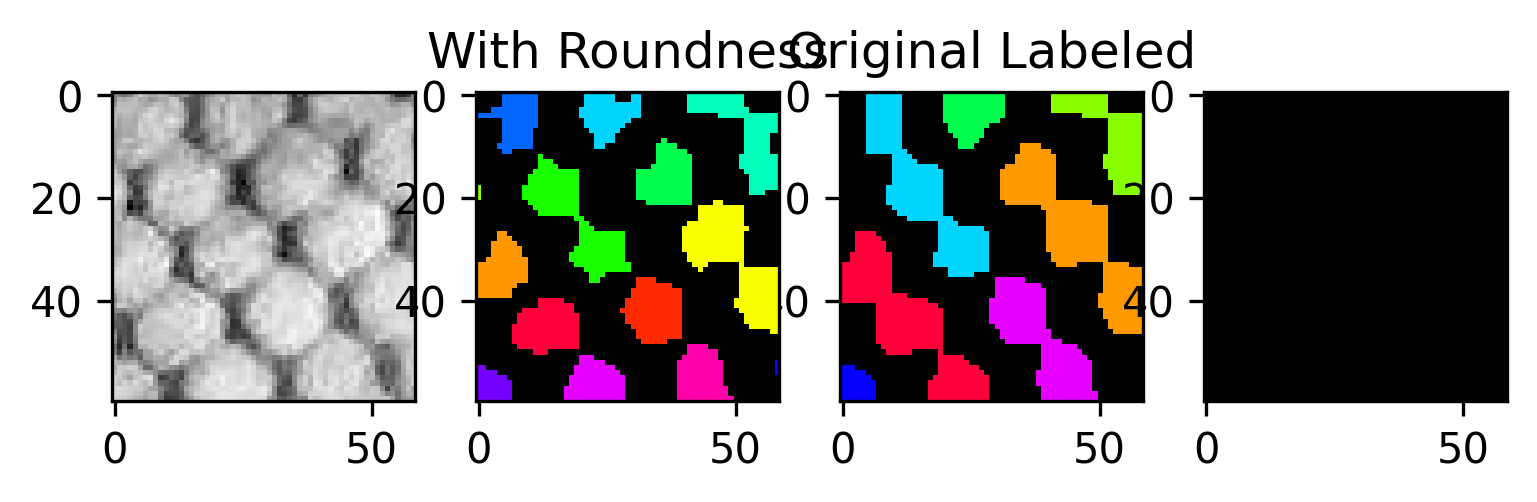

11
[INFO] 0 unique segments found
21
[INFO] 0 unique segments found
31
[INFO] 0 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

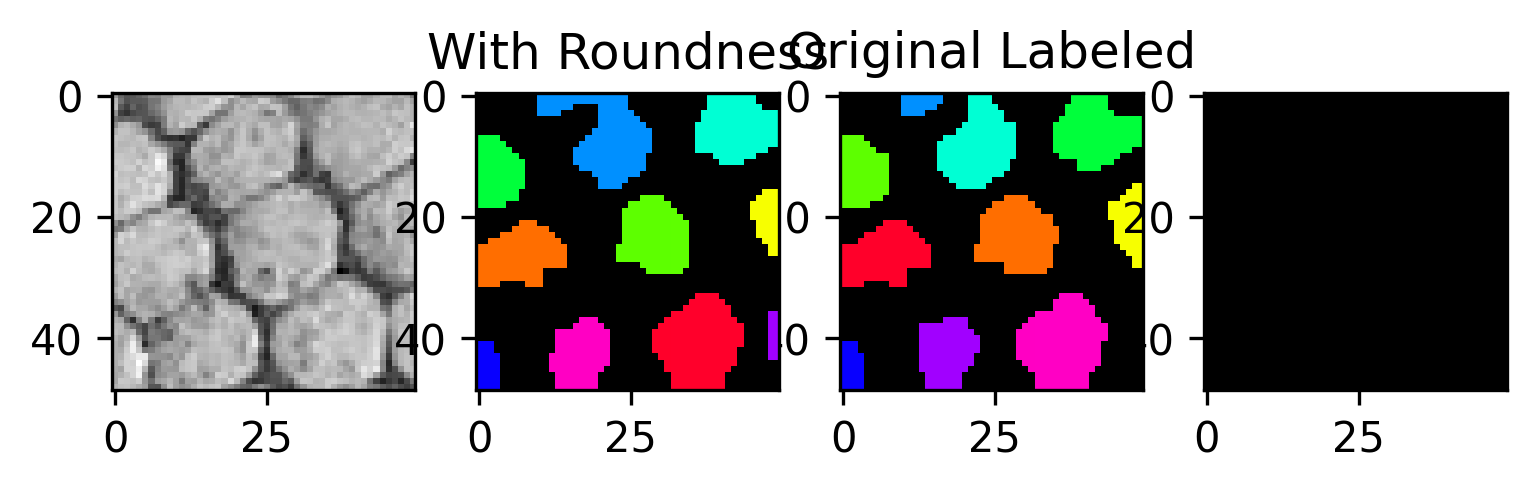

11
[INFO] 0 unique segments found
21
[INFO] 0 unique segments found
31
[INFO] 0 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

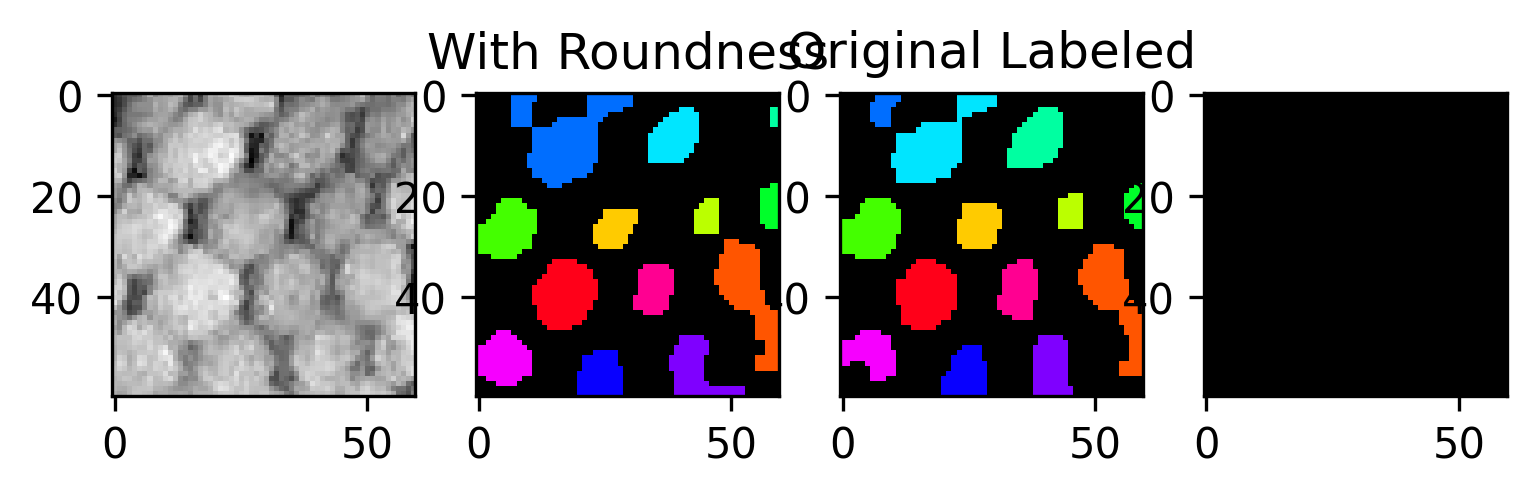

11
[INFO] 0 unique segments found
21
[INFO] 0 unique segments found
31
[INFO] 0 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

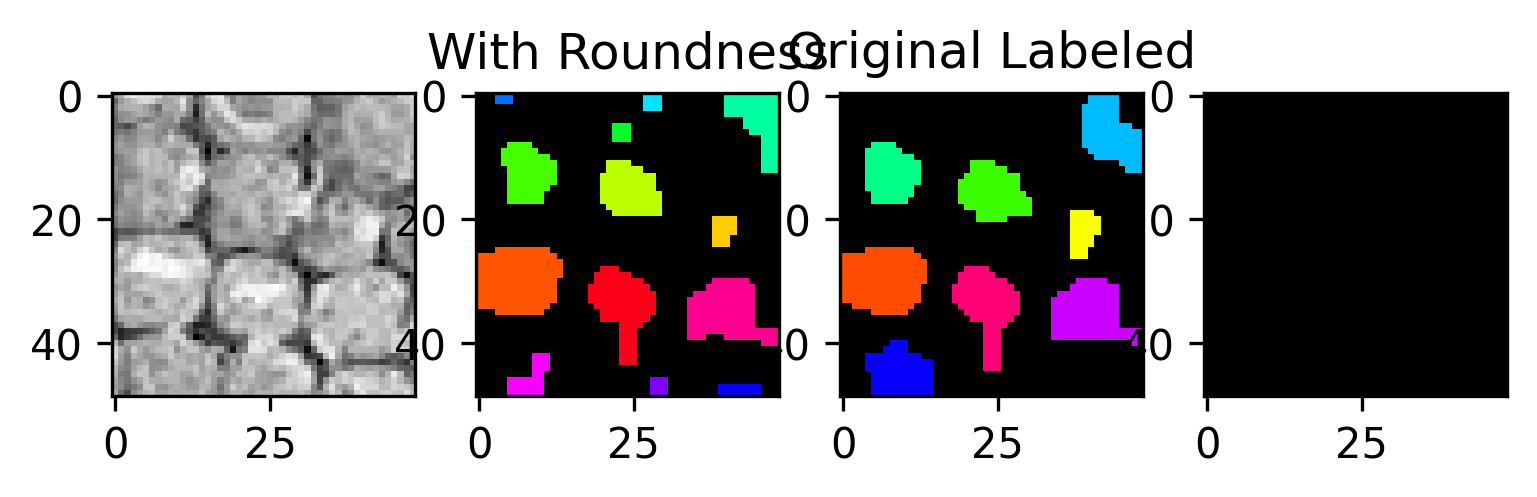

55
[INFO] 1 unique segments found
65
[INFO] 1 unique segments found
75
[INFO] 1 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

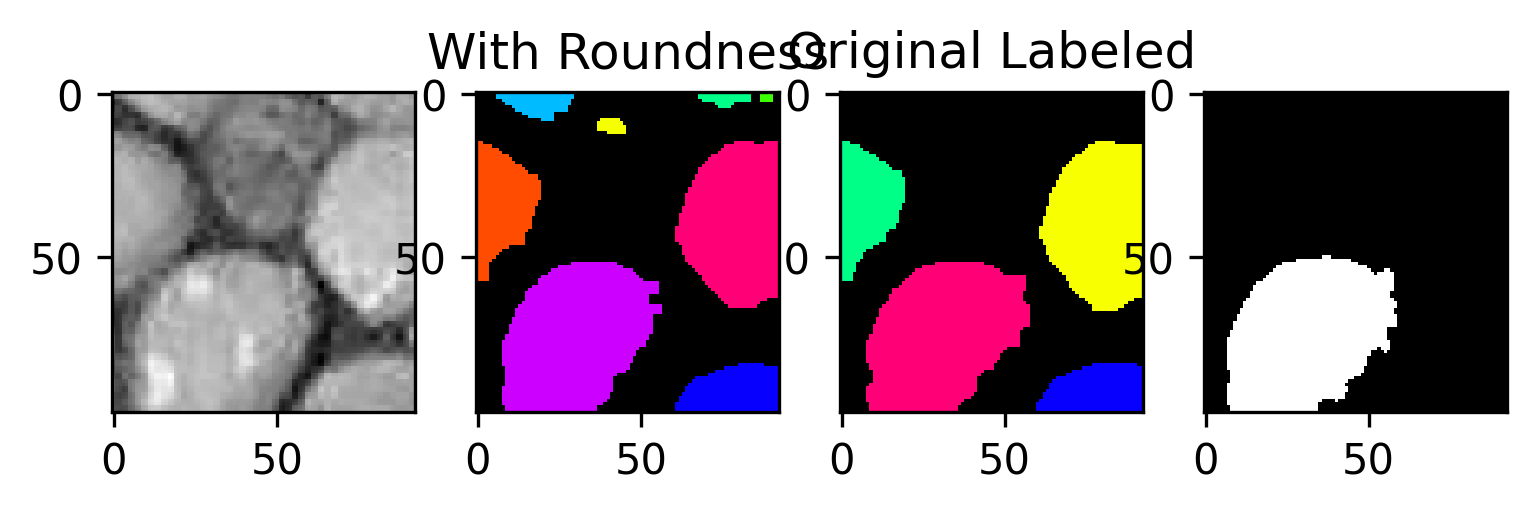

55
[INFO] 0 unique segments found
65
[INFO] 0 unique segments found
75
[INFO] 0 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

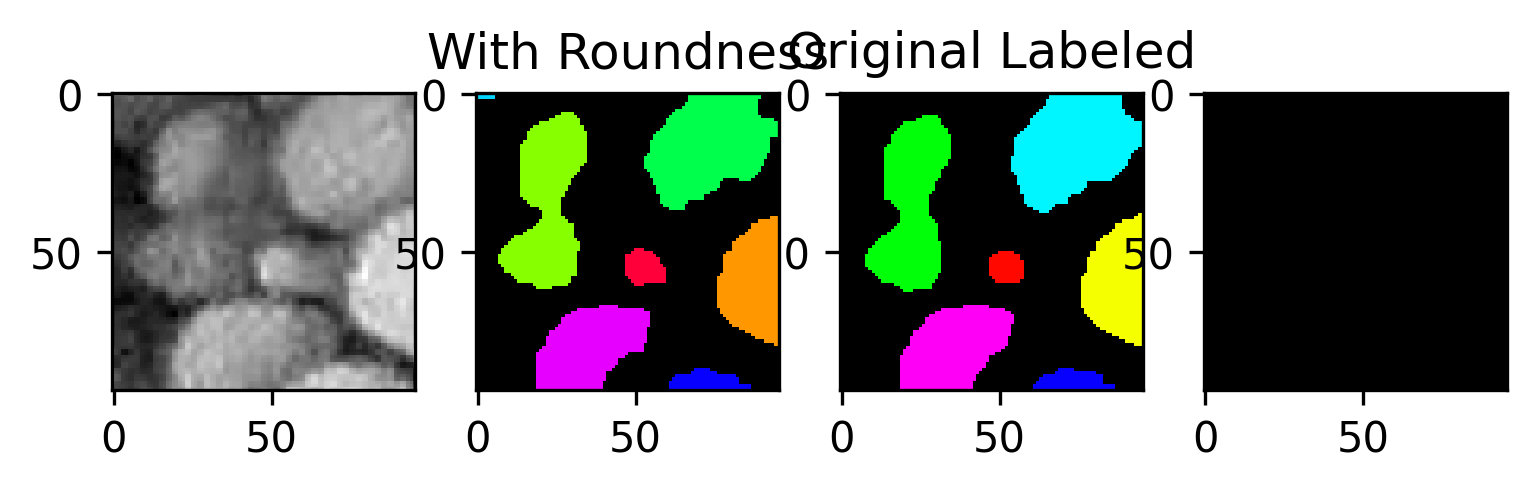

55
[INFO] 1 unique segments found
65
[INFO] 1 unique segments found
75
[INFO] 1 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

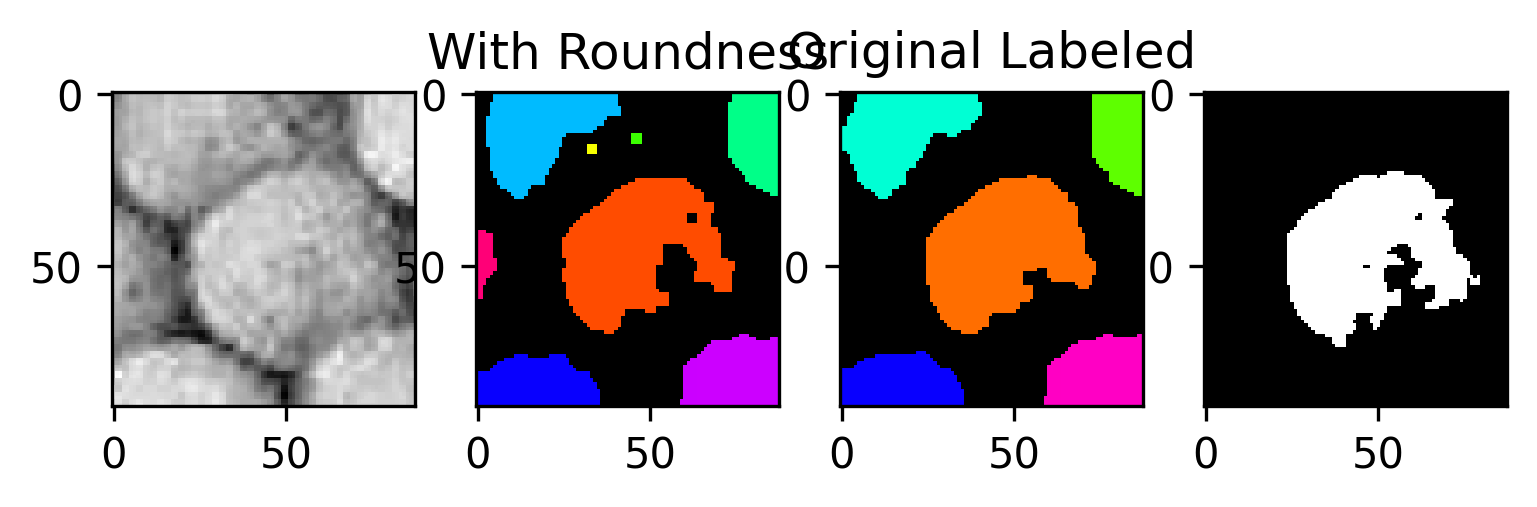

11
[INFO] 0 unique segments found
21
[INFO] 0 unique segments found
31
[INFO] 1 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

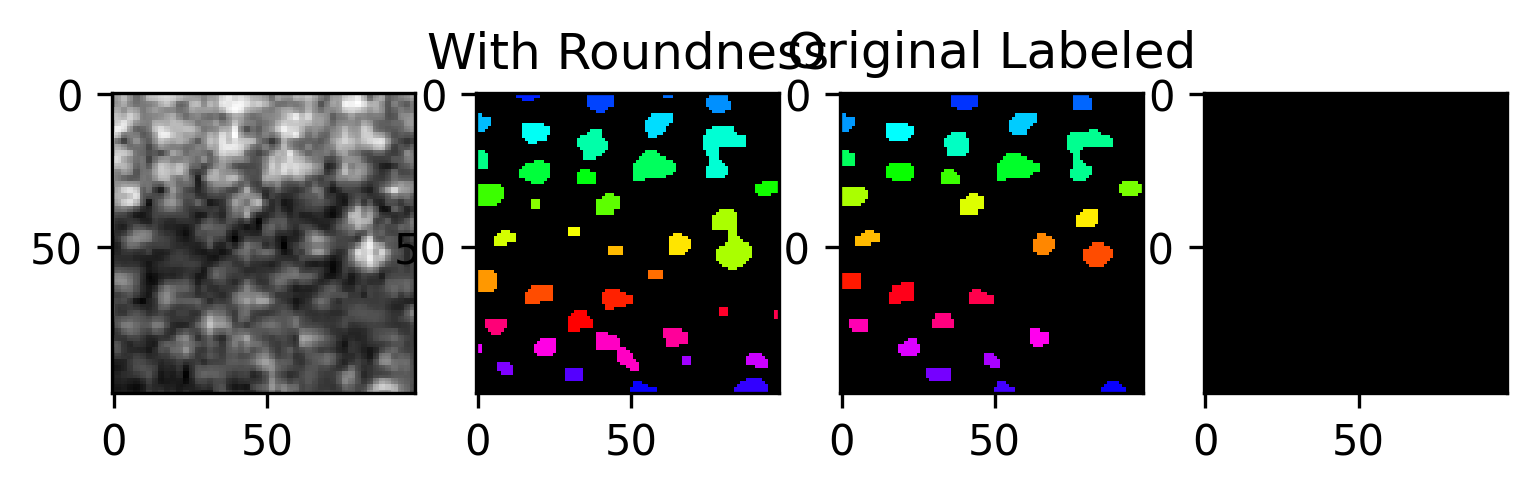

11
[INFO] 0 unique segments found
21
[INFO] 1 unique segments found
31
[INFO] 1 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

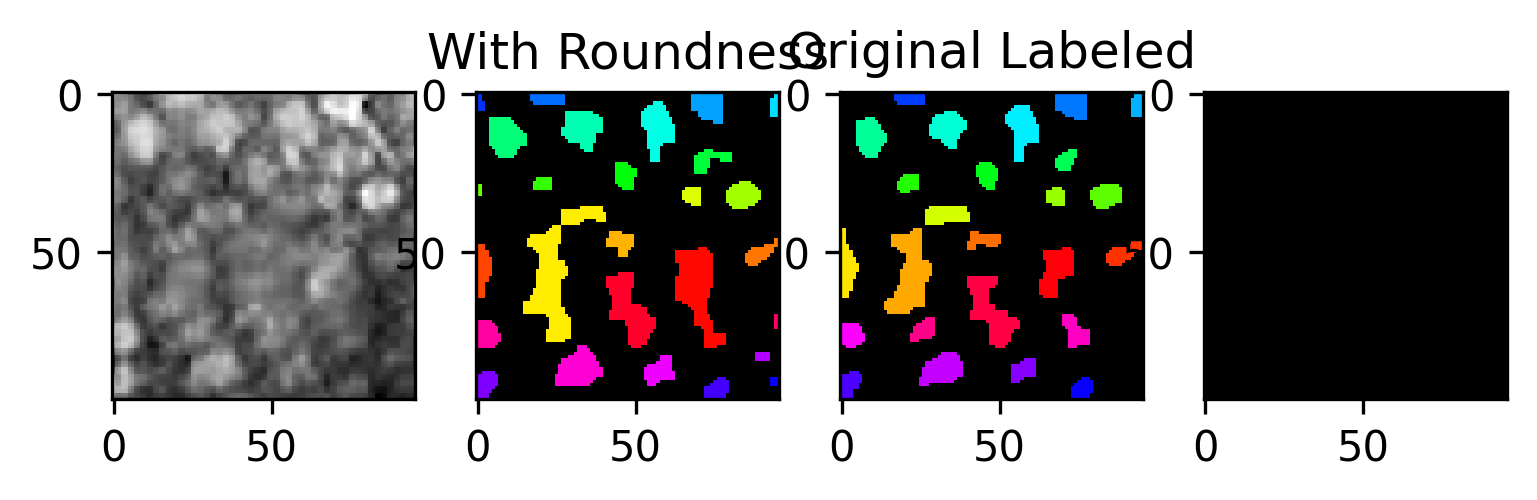

5
[INFO] 0 unique segments found
15
[INFO] 0 unique segments found
25
[INFO] 0 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

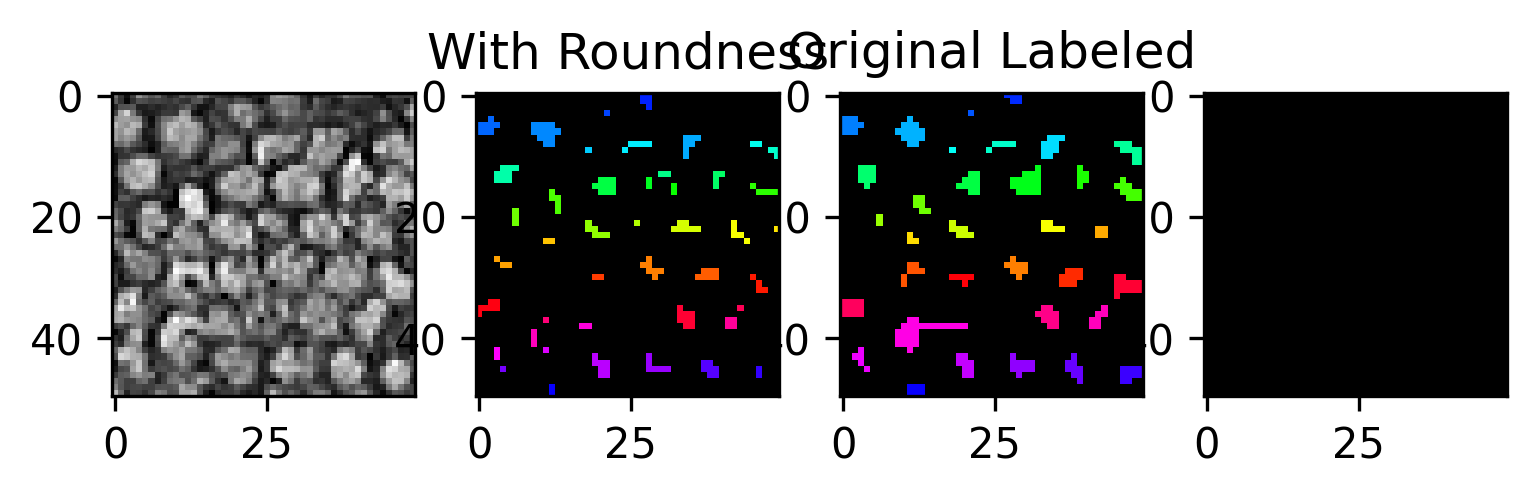

11
[INFO] 2 unique segments found
21
[INFO] 1 unique segments found
31
[INFO] 2 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

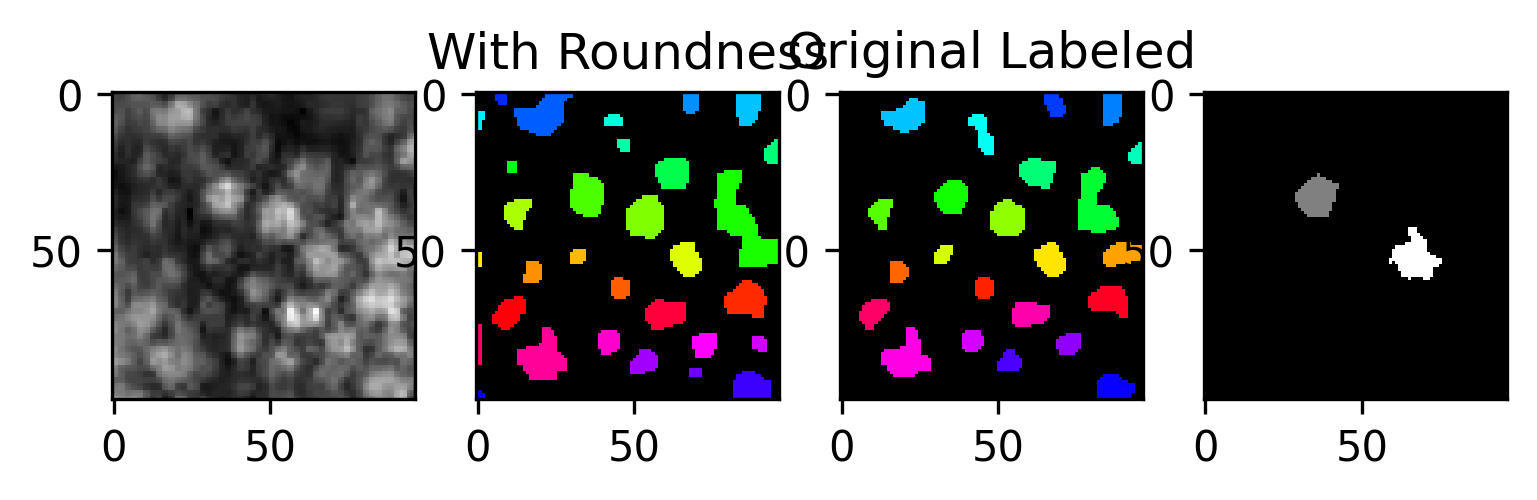

5
[INFO] 0 unique segments found
15
[INFO] 0 unique segments found
25
[INFO] 0 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

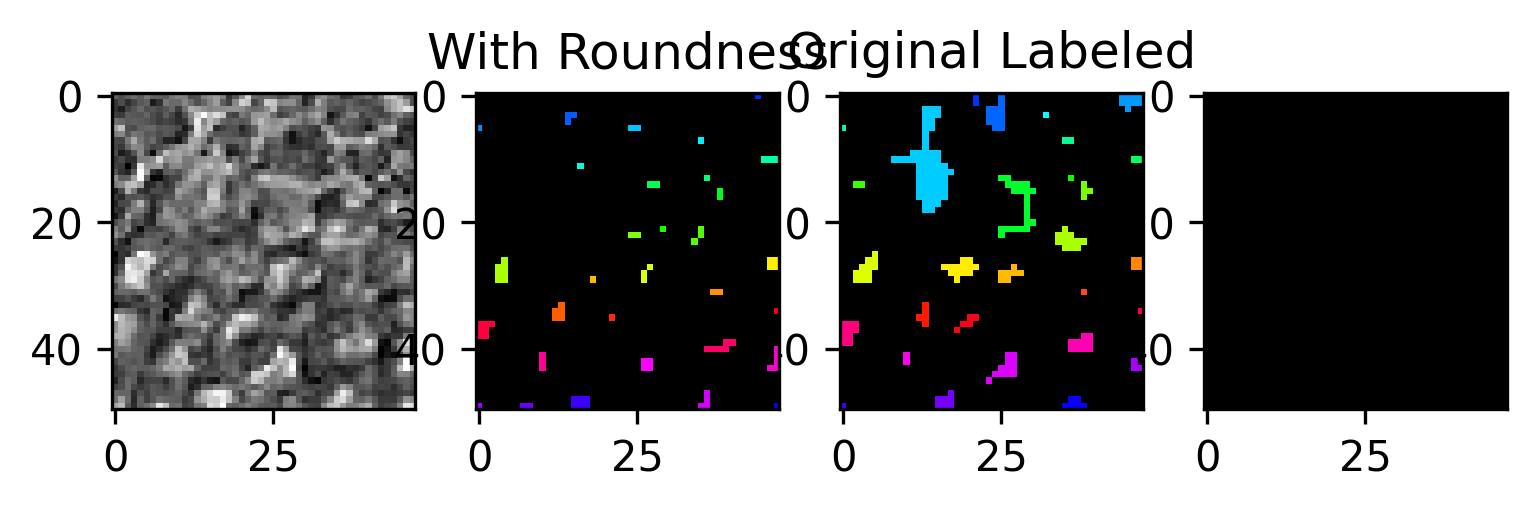

5
[INFO] 0 unique segments found
15
[INFO] 0 unique segments found
25
[INFO] 0 unique segments found


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=N

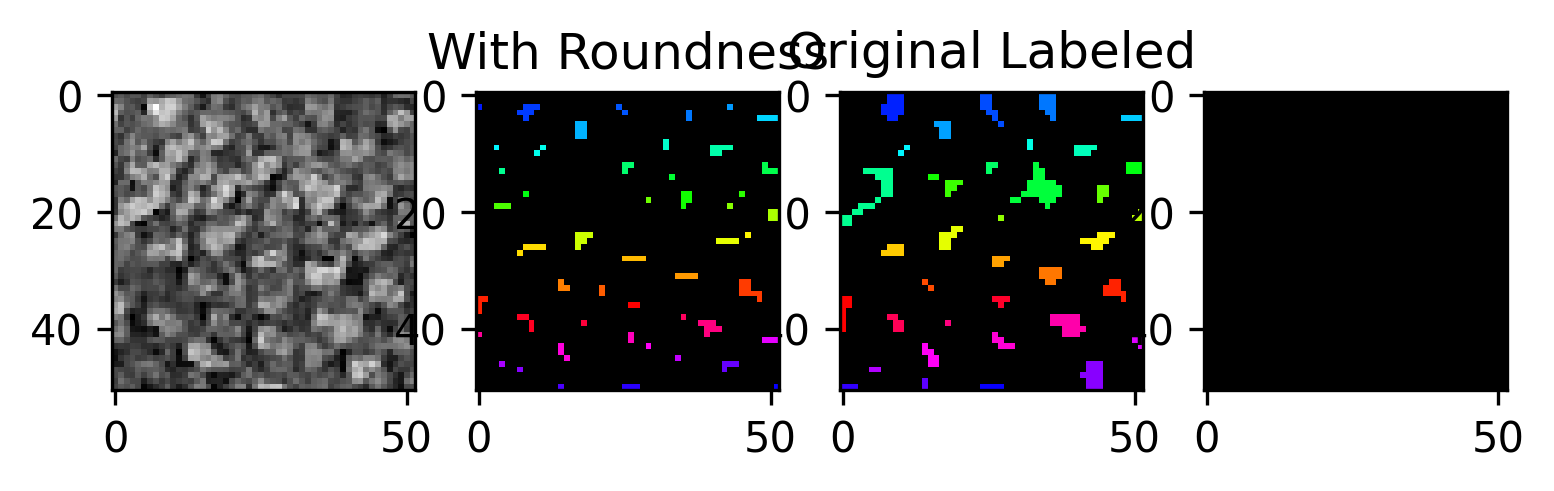

IndexError: list index out of range

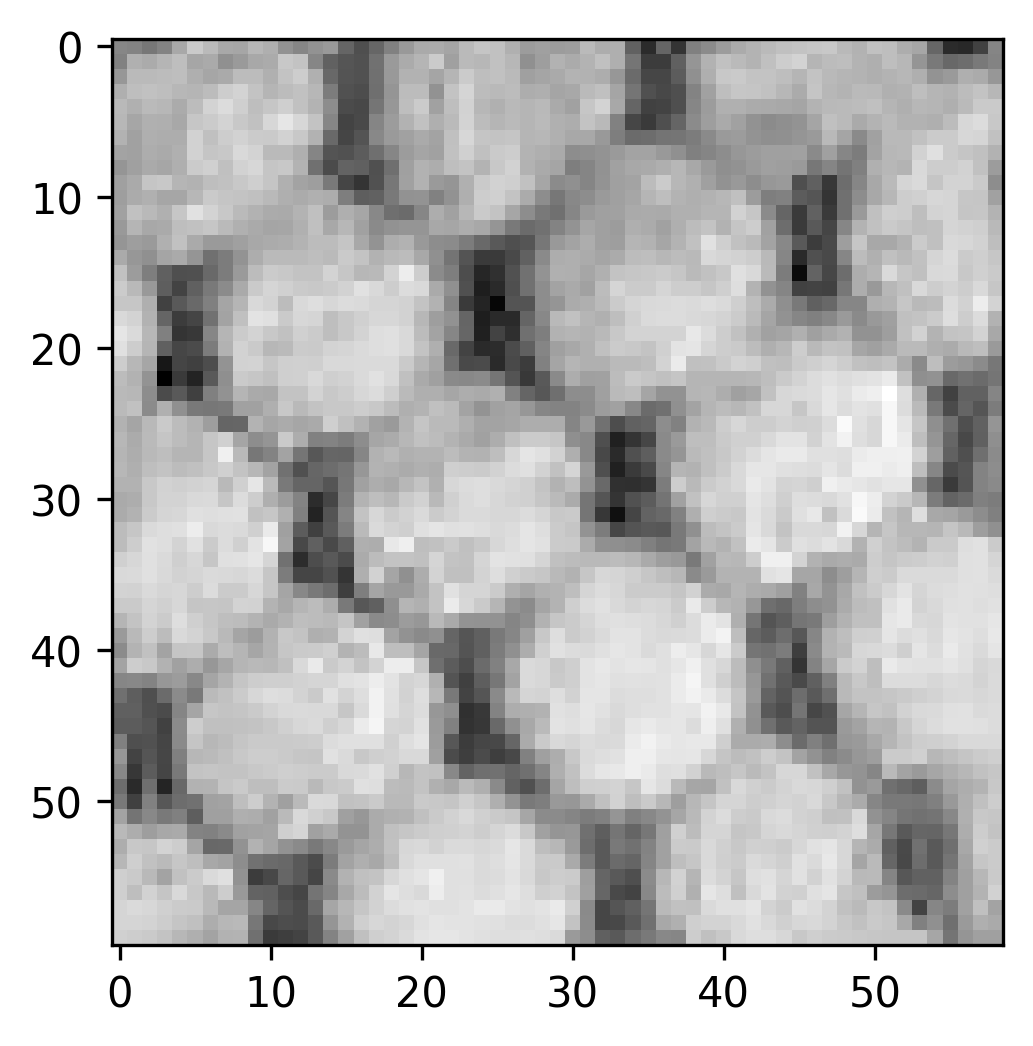

In [16]:
#THOUGHTS: COULD USE STANDARD DEVIATION: WHICH BLOCK SIZE MINIMIZES THE STANDARD DEVIATION OF THE SIZE? 
#BUT ALSO IF YOU DO THIS APPROACH MAY GET LESS SCALES


index = 0
for img in original_img:
    plt.imshow(img, "gray")
    ws = []
    countScales(img, block_size[index][0], without_r[index])
    index +=1